In [1]:
import numpy as np
from astropy.table import QTable
import astropy.coordinates as coord
import astropy.units as u

from galpy.potential import NFWPotential, HernquistPotential, MiyamotoNagaiPotential
from galpy.orbit import Orbit

# Importing data and transforming to Galactic Coordinates

In [2]:
# importing the data as an astropy table
# the data has been downloaded with the following criteria:
# - non null radial velocities
# - parallax_over_error > 5
# - ruwe <1 .4
# - parallax > 0.183 (to account for the parallax zero point of 0.017 mas)
gaia_rad = QTable.read("1629912465318O-result.csv")

In [3]:
# getting distance for each source
dist = coord.Distance(parallax = (u.Quantity(gaia_rad['parallax'] ) +0.017)*u.mas)

In [4]:
# Making a SkyCoord object to easily transform between coordinates
c = coord.SkyCoord(ra = gaia_rad['ra']*u.deg,
                   dec = gaia_rad['dec']*u.deg,
                   distance = dist,
                   pm_ra_cosdec = gaia_rad['pmra']*u.mas/u.year,
                   pm_dec = gaia_rad['pmdec']*u.mas/u.year,
                   radial_velocity = gaia_rad['dr2_radial_velocity']*u.km/u.s,
                   frame = 'icrs')

In [ ]:
orbits = Orbit(c)

# Setting up the Potential

# Obtaining the Quality Cut

In [8]:
# obtaining quality data sample
# by removing sources that do not fit our criteria: |V-V_LSR| > 210km/s and E < 0
index = np.logical_and( Toomre_Velocity.value> 210, E < 0)
quality_data = gaia_rad[index]

In [9]:
print('I started with',len(gaia_rad),'sources from the gaia radial velocity data')
print('Removing sources not within velocity criteria, there remains', np.sum(Toomre_Velocity.value > 210),'sources')
print('Removing the remaining',np.sum(Toomre_Velocity.value > 210)-len(quality_data),'sources with E>0')
print('I am left with:', len(quality_data),'sources')

I started with 5709139 sources from the gaia radial velocity data
Removing sources not within velocity criteria, there remains 48883 sources
Removing the remaining 4 sources with E>0
I am left with: 48879 sources


# Circularity

In [10]:
def Gal_Pot_circ(R):
    # galactic potential for an orbit with z = 0 and R = sqrt (x^2 + y^2)
    
    # Potential of the Halo
    pot_halo_num = -G * M_halo * (r_s/R) * np.log(1 + R/r_s)* c_h
    pot_halo_denom = r_vir * (np.log(1 + c_h)-(c_h/(1 + c_h))) 
    pot_halo = pot_halo_num / pot_halo_denom # in km^2/s^2

    # Potential of the Disk
    # I use z = 0 and x^2+y^2 = R^2
    denom_disk = np.sqrt(R**2 + (a_d + b_d )**2)  
    pot_disk = - G * M_disk / denom_disk # in km^2/s^2

    # Potential of the Bulge
    pot_bulge = - G * M_bulge / ( R +c_b)# in km^2/s^2

    # Total potential
    galactic_potential = pot_halo + pot_disk + pot_bulge # in km^2/s^2
    return galactic_potential

def inverse(E,a,b,c):
    # Simple model to find r_circular for a given Energy
    return ( a/(E+b) ) + c

(2.0, 20.0)

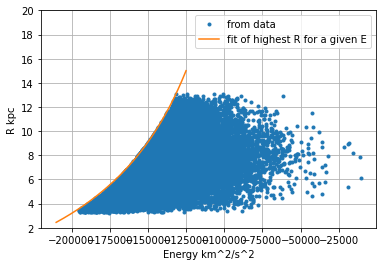

In [11]:
# Plotting R vs E for points in halo set
plt.plot(E[index],R[index], '.')

# Generating (E, R) pairs for circular orbits
np.random.seed(0)
R_test = np.random.uniform(low = 2.5, high = 15, size = 500)*u.kpc
Energy_test = Gal_Pot_circ(R_test)# km^2/s^2

# fitting the inverse function to the pairs of (E, R) of circular orbits
p0 = [-1e6,1,0]
x=np.arange(Energy_test.min().value,Energy_test.max().value,100)
popt, pcov = scipy.optimize.curve_fit(inverse,Energy_test,R_test, p0 = p0) 

# plotting the best fit to the circular orbit pairs
plt.plot(x, inverse(x, *popt))

plt.grid()
plt.xlabel('Energy km^2/s^2')
plt.ylabel('R kpc')
# the largest R value is that for a circular orbit
plt.legend(['from data', 'fit of highest R for a given E'])
plt.ylim(2,20)

In [12]:
# Finding L_max assuming that circular orbits are virialized
v_c = np.sqrt(-2*E[index])
r_c = inverse(E[index].value, *popt)*u.kpc
Lz_max = v_c*r_c
# Computing circularity
circ = L_z[index] / Lz_max

# Plotting the Results

/home/claudia/miniconda3/envs/DataScience/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/claudia/miniconda3/envs/DataScience/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


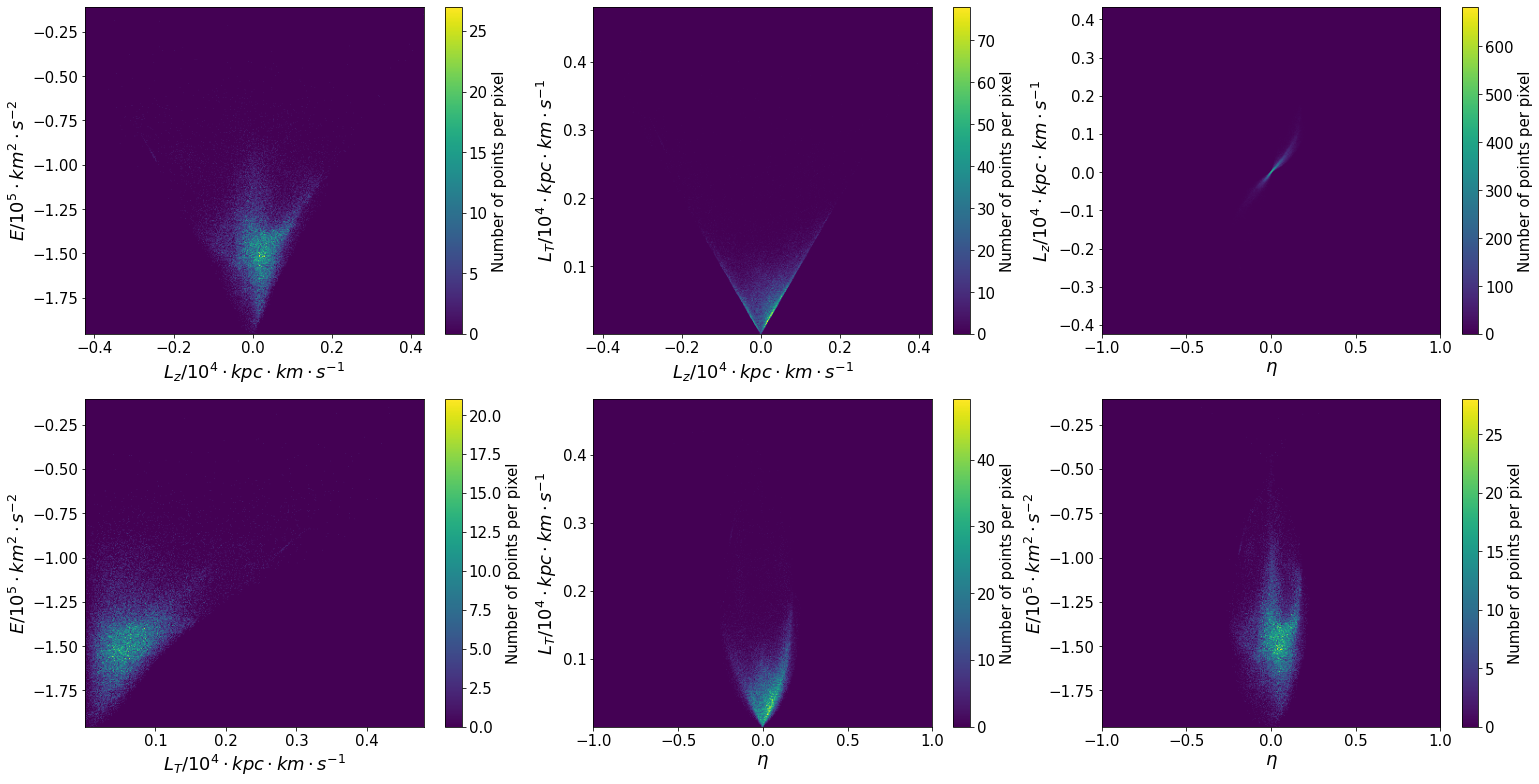

In [13]:
fig=plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size':15})
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

#------------------------------
# Energy vs L_z

ax = fig.add_subplot(231, projection='scatter_density')

density1 = ax.scatter_density(L_z.value[index]/10**4 , E.value[index]/ 10**5)
fig.colorbar(density1, label='Number of points per pixel')

plt.xlabel(r'$L_z / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize = 18)
plt.ylabel(r'$E / 10^5 \cdot km^2 \cdot s^{-2}$', fontsize=18)

#------------------------------
# L vs L_z

ax = fig.add_subplot(232, projection='scatter_density')

density2 = ax.scatter_density(L_z.value[index]/10**4 , L_T.value[index]/10**4 )
fig.colorbar(density2, label='Number of points per pixel')

plt.xlabel(r'$L_z / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize = 18)
plt.ylabel(r'$L_T / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize=18)

#--------------------------------
# L_z vs circularity

ax = fig.add_subplot(233, projection='scatter_density')

density3 = ax.scatter_density(circ , L_z.value[index]/10**4)
fig.colorbar(density3, label='Number of points per pixel')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$L_z / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize=18)
plt.xlim(-1,1)

#---------------------------------
# E vs L

ax = fig.add_subplot(234, projection='scatter_density')

density4 = ax.scatter_density(L_T.value[index]/10**4 ,  E.value[index]/ 10**5 )
fig.colorbar(density4, label='Number of points per pixel')

plt.xlabel(r'$L_T / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize = 18)
plt.ylabel(r'$E / 10^5 \cdot km^2 \cdot s^{-2}$', fontsize=18)

#---------------------------------
# L vs circularity

ax = fig.add_subplot(235, projection='scatter_density')

density5 = ax.scatter_density(circ  , L_T.value[index]/10**4)
fig.colorbar(density5, label='Number of points per pixel')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$L_T / 10^4 \cdot kpc \cdot km \cdot s^{-1}$', fontsize=18)
plt.xlim(-1,1)

#---------------------------------
# E vs circularity

ax = fig.add_subplot(236, projection='scatter_density')

density6 = ax.scatter_density(circ ,  E.value[index]/ 10**5)
fig.colorbar(density6, label='Number of points per pixel')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$E / 10^5 \cdot km^2 \cdot s^{-2}$',fontsize=18)
plt.xlim(-1,1)

plt.show()


/tmp/ipykernel_2335/766310965.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(density1.get_array()), cmap='afmhot', extent = density1.get_extent(), aspect = 'auto')
/tmp/ipykernel_2335/766310965.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(density2.get_array()), cmap='afmhot', extent = density2.get_extent(), aspect = 'auto')
/tmp/ipykernel_2335/766310965.py:33: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(density3.get_array()), cmap='afmhot', extent = density3.get_extent(), aspect = 'auto')
/tmp/ipykernel_2335/766310965.py:44: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(density4.get_array()), cmap='afmhot', extent = density4.get_extent(), aspect = 'auto')
/tmp/ipykernel_2335/766310965.py:56: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(density5.get_array()), cmap='afmhot', extent = density5.get_extent(), aspect = 'auto')
/tmp/ipykernel_2335/766310965.

Text(0, 0.5, '$E / 10^5$')

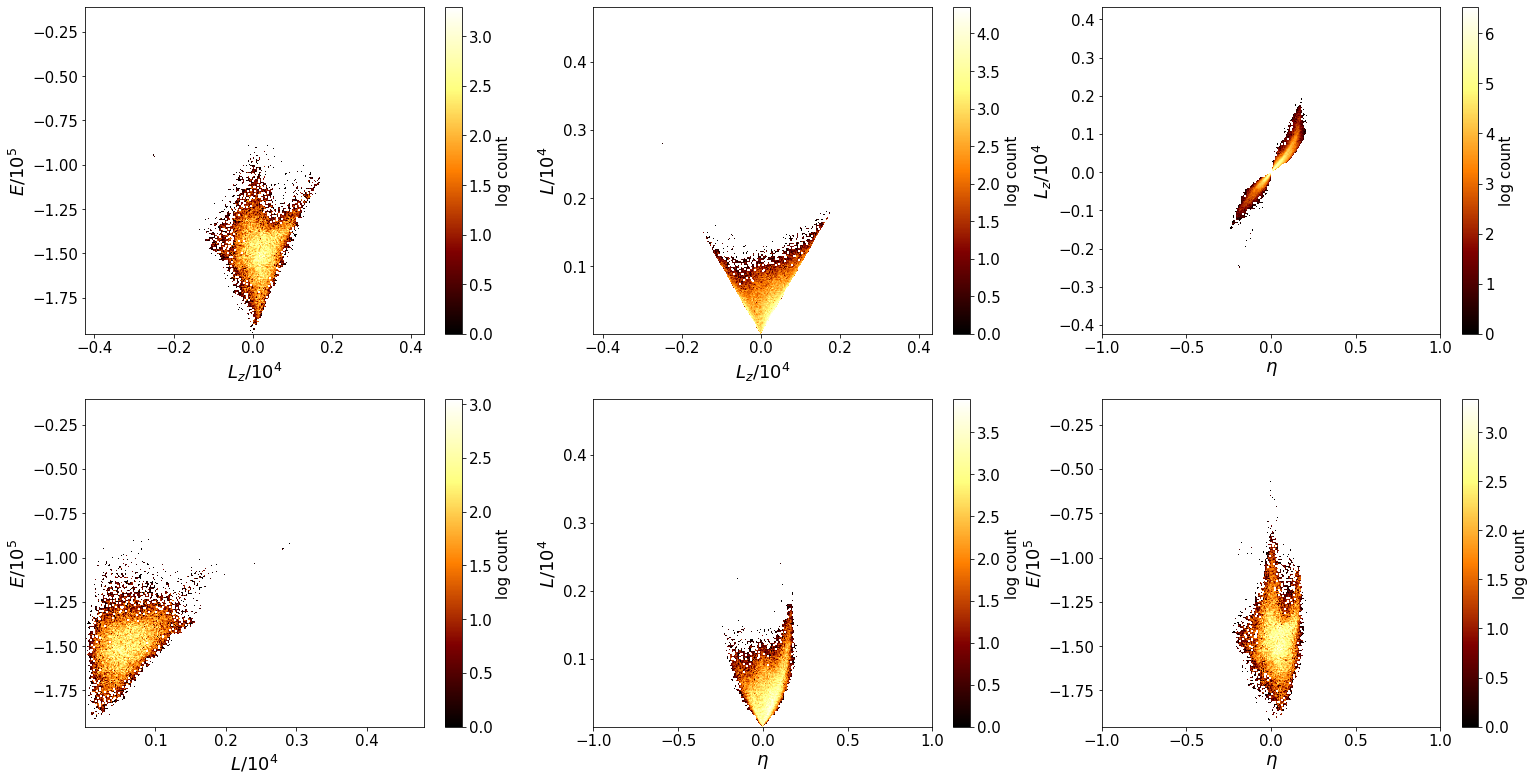

In [14]:
fig=plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size':15})
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

#------------------------------
# Energy vs L_z

ax = fig.add_subplot(231)

plt.imshow(np.log(density1.get_array()), cmap='afmhot', extent = density1.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count')

plt.xlabel(r'$L_z / 10^4$', fontsize = 18)
plt.ylabel(r'$E / 10^5$', fontsize=18)

#------------------------------
# L vs L_z

ax = fig.add_subplot(232)

plt.imshow(np.log(density2.get_array()), cmap='afmhot', extent = density2.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count') 

plt.xlabel(r'$L_z / 10^4$', fontsize = 18)
plt.ylabel(r'$L / 10^4$', fontsize=18)


#--------------------------------
# L_z vs circularity

ax = fig.add_subplot(233)

plt.imshow(np.log(density3.get_array()), cmap='afmhot', extent = density3.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$L_z / 10^4$', fontsize=18)

#---------------------------------
# E vs L

ax = fig.add_subplot(234)

plt.imshow(np.log(density4.get_array()), cmap='afmhot', extent = density4.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count')

plt.xlabel(r'$L / 10^4$', fontsize = 18)
plt.ylabel(r'$E / 10^5$', fontsize=18)


#---------------------------------
# L vs circularity

ax = fig.add_subplot(235)

plt.imshow(np.log(density5.get_array()), cmap='afmhot', extent = density5.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$L / 10^4$', fontsize=18)

#---------------------------------
# E vs circularity

ax = fig.add_subplot(236)

plt.imshow(np.log(density6.get_array()), cmap='afmhot', extent = density6.get_extent(), aspect = 'auto')
plt.colorbar(label = 'log count')

plt.xlabel(r'$\eta$', fontsize = 18)
plt.ylabel(r'$E / 10^5$',fontsize=18)


In [15]:
np.savetxt('E_Lz_LT_circ.csv', (E.value[index],L_z.value[index] , L_T.value[index], circ), delimiter = ',')

In [18]:
L_T.value[index]

array([224.82655895, 655.88730455, 613.22571023, ..., 502.46970981,
       228.49586153, 347.94946659])